In [1]:
suppressPackageStartupMessages(require(tidyverse))
suppressPackageStartupMessages(require(data.table))


In [2]:
meta_tbl_f <- '/oak/stanford/groups/mrivas/projects/biomarkers_rivas/meta/METAANALYSIS_Calcium_1.tbl'

pvar_f <- '/oak/stanford/groups/mrivas/ukbb24983/cal/pgen/ukb24983_cal_cALL_v2_hg19.pvar'


In [3]:
pvar_df <- fread(pvar_f) %>% rename('CHROM' = '#CHROM')

meta_sumstats_df <- fread(meta_tbl_f)

joined_df <- pvar_df %>% rename('MarkerName' = 'ID') %>%
right_join(meta_sumstats_df, by='MarkerName') %>%
mutate(
    A1_is_ref = (toupper(Allele1) == toupper(REF)),    
    A1_is_alt = (toupper(Allele1) == toupper(ALT)),
    A2_is_ref = (toupper(Allele2) == toupper(REF)),    
    A2_is_alt = (toupper(Allele2) == toupper(ALT)),
    is_not_flipped = (A1_is_alt & A2_is_ref),
    is_flipped     = (A1_is_ref & A2_is_alt)
)


In [4]:
print('Count summary')

joined_df%>%
count(A1_is_alt, A2_is_ref, A1_is_ref, A2_is_alt) %>%
print()


[1] "Count summary"
# A tibble: 2 x 5
  A1_is_alt A2_is_ref A1_is_ref A2_is_alt      n
  <lgl>     <lgl>     <lgl>     <lgl>      <int>
1 FALSE     FALSE     TRUE      TRUE      334456
2 TRUE      TRUE      FALSE     FALSE     445610


In [6]:
gwas_f <- '/oak/stanford/groups/mrivas/projects/biomarkers_rivas/main/w_british/ukb24983_v2_hg19.Calcium.genotyped.glm.linear.gz'
gwas_df <- fread(cmd=paste0('zcat ', gwas_f))

Warning message:
“Removed 901 rows containing missing values (geom_point).”

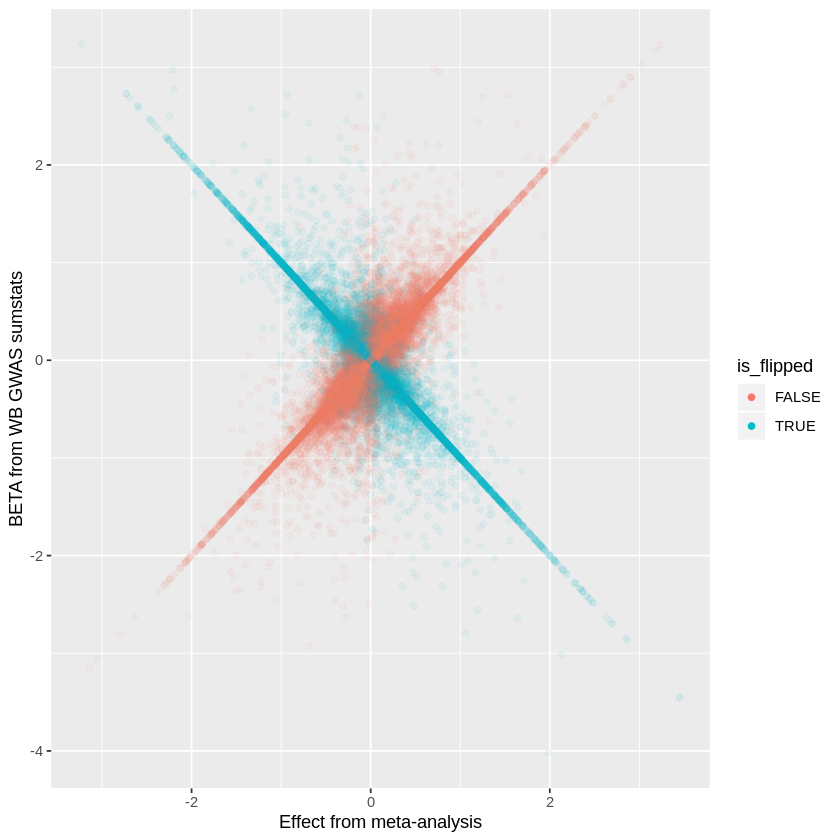

In [19]:
joined_df %>% 
rename('P' = 'P-value') %>%
filter(P < 5e-8) %>%
select(MarkerName, Effect, is_flipped) %>% 
inner_join(gwas_df %>% select(ID, BETA) %>% rename('MarkerName' = 'ID'), by='MarkerName') %>%
ggplot(aes(x=Effect, y=BETA, color=is_flipped)) +
geom_point(alpha=0.05) + 
labs(
    x = 'Effect from meta-analysis',
    y = 'BETA from WB GWAS sumstats'
)+
guides(colour = guide_legend(override.aes = list(alpha = 1))) 

In [20]:
flipfixed_f <- '/oak/stanford/groups/mrivas/projects/biomarkers_rivas/meta_flipfixed/METAANALYSIS_Calcium_1.tbl.gz'
flipfixed_df <- fread(cmd=paste0('zcat ', flipfixed_f))


Warning message:
“Removed 901 rows containing missing values (geom_point).”

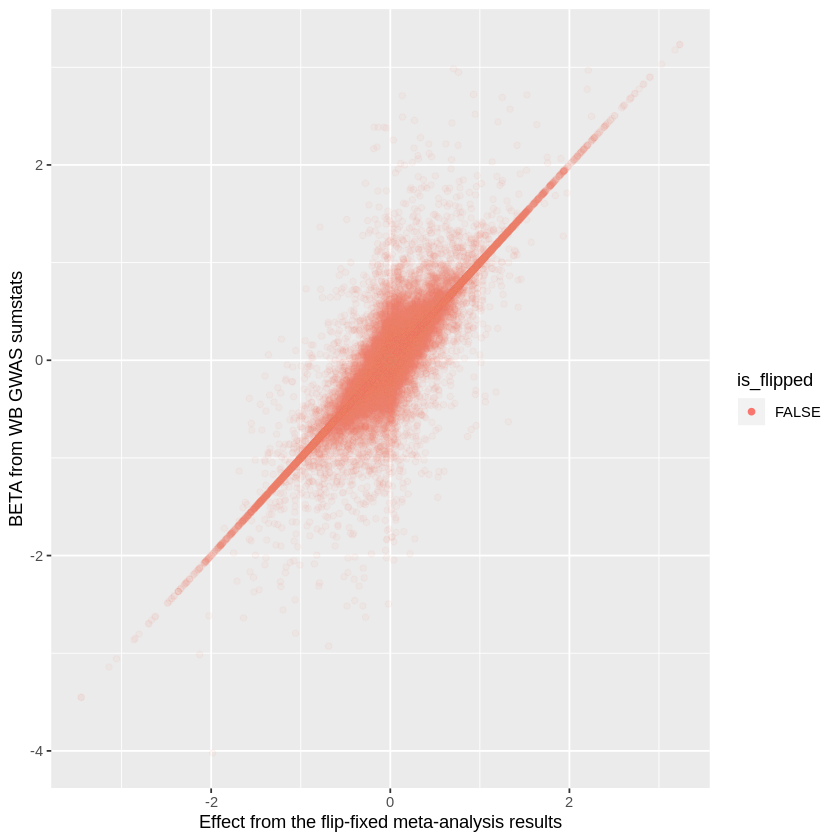

In [23]:
pvar_df %>% rename('MarkerName' = 'ID') %>%
right_join(
    flipfixed_df %>% rename('Allele1' = 'ALT', 'Allele2' = 'REF'), 
    by='MarkerName'
) %>%
mutate(
    A1_is_ref = (toupper(Allele1) == toupper(REF)),    
    A1_is_alt = (toupper(Allele1) == toupper(ALT)),
    A2_is_ref = (toupper(Allele2) == toupper(REF)),    
    A2_is_alt = (toupper(Allele2) == toupper(ALT)),
    is_not_flipped = (A1_is_alt & A2_is_ref),
    is_flipped     = (A1_is_ref & A2_is_alt)
) %>% 
rename('P' = 'P-value') %>%
filter(P < 5e-8) %>%
select(MarkerName, Effect, is_flipped) %>% 
inner_join(gwas_df %>% select(ID, BETA) %>% rename('MarkerName' = 'ID'), by='MarkerName') %>%
ggplot(aes(x=Effect, y=BETA, color=is_flipped)) +
geom_point(alpha=0.05) + 
labs(
    x = 'Effect from the flip-fixed meta-analysis results',
    y = 'BETA from WB GWAS sumstats'
)+
guides(colour = guide_legend(override.aes = list(alpha = 1))) 
